# Lab7
## Implementacion de arquitectura ***LeNet5***

grupo:
- Diego Cordova: 20212
- Marco Jurado: 20308
- Cristian Aguirre: 20231

### Carga de datos

In [187]:
from tensorflow import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

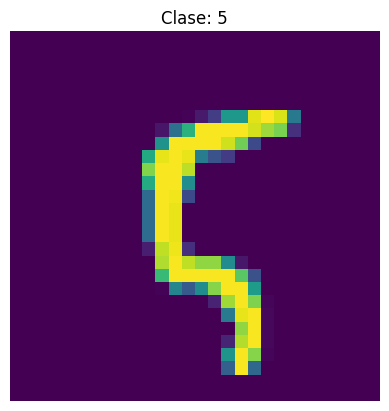

In [188]:
import matplotlib.pyplot as plt

# Mostrar una imagen de ejemplo del conjunto de entrenamiento
sample_image = x_train[100]  # Cambia el índice para ver diferentes imágenes
sample_label = y_train[100]  # Etiqueta de la imagen de ejemplo

# Dado que las imágenes están en color (3 canales), puedes usar plt.imshow para visualizarlas
plt.imshow(sample_image)
plt.title(f'Clase: {sample_label}')
plt.axis('off')  # Desactivar los ejes para una mejor visualización
plt.show()

### Imports y verificacion de GPU

In [189]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Red LeNet5

In [190]:
from torch.nn.modules import activation
# Arquitectura basada en:
# https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            # Capa convolucional Conv1
            # - 6 kernels de 5x5
            # - stride de 1
            # - activacion tanh
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),

            # Capa de Max Pooling Pool1
            # - kernel de 2x2
            # - stride de 2
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Capa convolucional Conv2
            # - 16 kernels de 5x5
            # - stride de 1
            # - activacion tanh
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),

            # Capa de Max Pooling Pool2
            # - kernel de 2x2
            # - stride de 2
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Capa convolucional Conv2
            # - 120 kernels de 5x5
            # - stride de 1
            # - activacion tanh
            nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
        )

        # Calcular el tamaño de la salida de las capas convolucionales
        self.fc_input_size = self._get_conv_output_size((1, 28, 28))

        self.classifier = nn.Sequential(
            # Capa totalmente conectada (FC1)
            # - Activacion Tanh
            nn.Linear(self.fc_input_size, 84),
            nn.Tanh(),

            # Capa de salida con num_classes
            # - Activacion softmax
            nn.Linear(84, num_classes),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Aplanar la salida de la última capa convolucional
        x = self.classifier(x)
        return x

    def _get_conv_output_size(self, shape):
        x = torch.rand(shape)
        x = self.features(x)
        return x.view(1, -1).size(1)

net = LeNet5()

# Imprimir la arquitectura de la red
print(net)

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=5880, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)


In [191]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Transformaciones de datos para escalar las imágenes a [0, 1] y convertirlas a tensores
transform = transforms.Compose([transforms.ToTensor()])

# Cargar el conjunto de datos MNIST
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

# Crear DataLoader para cargar lotes de datos
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [192]:
import torch.optim as optim

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epochs = 10

# Entrenamiento
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

print('Finished Training')

# Evaluación en el conjunto de prueba
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total}%')


Epoch 1, Loss: 2.2981879690816918
Epoch 2, Loss: 2.232636973039428
Epoch 3, Loss: 1.8796762557172064
Epoch 4, Loss: 1.7117158437588575
Epoch 5, Loss: 1.6303758567838527
Epoch 6, Loss: 1.594253583757608
Epoch 7, Loss: 1.5732828763756417
Epoch 8, Loss: 1.558727065510333
Epoch 9, Loss: 1.547953422516902
Epoch 10, Loss: 1.539352385728344
Finished Training
Accuracy on test set: 94.47%
